# Functional Annotation

In [1]:
features = [
    'GCA_016607445_AAYRPE010000019.1_24',
    'GCA_017007995_AAYXXU010000027.1_19',
    'GCA_001756025_CP074663.1_2689',
    'GCA_018276085_ABAJIZ010000002.1_500',
    'GCA_016724965_AAYTTP010000006.1_297',
    'GCA_004222645_CP074607.1_52',
    'GCA_010383125_CP082662.1_1183',
    'GCA_017008295_AAYXYG010000001.1_246',
    'GCA_016992765_AAYXEW010000001.1_177',
    'GCA_018228085_ABAINK010000011.1_102'
]
folder = "data/allProdigal/results/modified2/"

In [1]:
features = ['GCA_015911845_JACWPD010000188.1',
'GCA_015910915_JACWNS010001183.1',
'GCA_015911285_JACWQJ010001824.1',
'GCA_015910915_JACWNS010000283.1',
'GCA_015910915_JACWNS010000890.1',
'GCA_001644795_JXAY01000079.1',
'GCA_000749995_JQOI01000050.1',
'GCA_015911285_JACWQJ010003052.1',
'GCA_015911515_JACWOO010000083.1',
'GCA_015910975_JACWNV010000269.1',]
folder = "ncbi_dataset/ncbi_dataset/data/allProdigal/results/modified_faa"

In [2]:
import os

sequence_dict = {}  # Initialize an empty dictionary to store sequences

for feature in features:
    prefix = feature[:13]  # Use the first 13 characters as the prefix
    
    # Get a list of all files in the folder
    all_files = os.listdir(folder)
    
    # Filter the files that start with the specified prefix
    matching_files = [file for file in all_files if file.startswith(prefix)]
    
    if matching_files:
        fasta_file = os.path.join(folder, matching_files[0])  # Assuming there's only one matching file
        target_header = ">" + feature  # Convert the feature to FASTA header format
        
        found_sequence_lines = []
        found_sequence = None
        
        with open(fasta_file, 'r') as fasta:
            in_sequence = False
            for line in fasta:
                if line.startswith(target_header):
                    in_sequence = True
                    found_sequence_lines.append(line)
                elif in_sequence and line.startswith('>'):
                    break
                elif in_sequence:
                    found_sequence_lines.append(line)
        
        if found_sequence_lines:
            found_sequence = "".join(found_sequence_lines[1:])  # Concatenate sequence lines
        
        # Store the sequence in the dictionary with the feature as the key
        sequence_dict[feature] = found_sequence

# Now, sequence_dict contains all the sequences with features as keys
for feature, sequence in sequence_dict.items():
    print(f"Feature: {feature}")
    print(f"Sequence: {sequence}\n")


Feature: GCA_015911845_JACWPD010000188.1
Sequence: FTAEITTQLEQLETRYPRLRDFITEVLAQDPRPAYRKEEDAGKTYAVWLLDFNVRWRVTG
AGFEVFALEPR*


Feature: GCA_015910915_JACWNS010001183.1
Sequence: SKEGADYVRATATEDLIPGISPSDGALEVSNVDVGEALIGRLQTIGEEFATEVEGWQVDR
VRSVLRTGRYFHGIYYPKAFQIDGRKYVHGLA


Feature: GCA_015911285_JACWQJ010001824.1
Sequence: HVLGCACGKPFLSDELYDEVRTAAPYASLSRTDFDDVVDFVATGGYALKTYERFARIKQD
KQGRWRVTNPKVRQSYRLNVGTIVEETMMKVRLVRSRAGGTGSTGAIARGGRIL


Feature: GCA_015910915_JACWNS010000283.1
Sequence: MKYLDEFRDSGKARVLIKEIEALVATMRMPAERPLYIMEVCGGHTHSIFRYGLEGMLPKE
IGLIHGPGCPVCVLPMGRVDD
>GCA_015910915_JACWNS010000283.1_2
RAGDALIGISTSGNSANLMSAFAKAKEMGLVTIGLAGGDGGKMKSSGAVDFCLVVPTTSI
HRVQECHVAAYHILWDLVHTLLADDRGSAATKGAAA*


Feature: GCA_015910915_JACWNS010000890.1
Sequence: MALALSPEDAAFRDEVRAFIKDNYPAEMRVANPETDLSKEQMLLWHRI
>GCA_015910915_JACWNS010000890.1_2
RIEALGPNALDNPDLLMPPASVAASYWQLYQQPKSAWTFELEIRPFGEKW*


Feature: GCA_001644795_JXAY01000079.1
Sequence: MNQHDHGEDNKVQTRKGFWKAFIVTGESPEAVEPAKATLN
>GCA_0016

In [6]:
import requests

def query_uniprot(sequence):
    """Query UniProt API to get COG category and gene function description."""
    url = "https://www.uniprot.org/uploadlists/"
    params = {
        "from": "SEQUENCE",
        "to": "ACC",
        "format": "tab",
        "query": sequence
    }
    headers = {
        "Content-Type": "application/x-www-form-urlencoded"
    }
    response = requests.post(url, data=params, headers=headers)
    if response.status_code == 200:
        return response.text
    else:
        return "Failed to retrieve data"

def parse_uniprot_data(data):
    """Parse the results from UniProt to extract COG category and description."""
    lines = data.strip().split('\n')
    results = []
    for line in lines[1:]:  # Skip header line
        parts = line.split('\t')
        if len(parts) > 1:
            uniprot_id = parts[1]
            results.append(get_uniprot_entry(uniprot_id))
    return results

def get_uniprot_entry(uniprot_id):
    """Retrieve the UniProt entry based on the UniProt ID and extract details."""
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.txt"
    response = requests.get(url)
    if response.status_code == 200:
        return extract_details(response.text)
    return {}

def extract_details(entry_text):
    """Extract COG category and description from the UniProt entry text."""
    cog_category = None
    description = None
    for line in entry_text.split('\n'):
        if line.startswith("CC   -!- COG:"):
            cog_category = line.split(":")[1].strip()
        if line.startswith("DE   RecName: Full="):
            description = line.split("=")[1].strip(';')
    print(cog_category, description) 
    return {"COG Category": cog_category, "Description": description}

# Store results
results = {}

for feature_name, sequence in sequence_dict.items():
    uniprot_response = query_uniprot(sequence)
    results[feature_name] = parse_uniprot_data(uniprot_response)

# Output results
for feature, data in results.items():
    print(feature, data)


GCA_015911845_JACWPD010000188.1 []
GCA_015910915_JACWNS010001183.1 []
GCA_015911285_JACWQJ010001824.1 []
GCA_015910915_JACWNS010000283.1 []
GCA_015910915_JACWNS010000890.1 []
GCA_001644795_JXAY01000079.1 []
GCA_000749995_JQOI01000050.1 []
GCA_015911285_JACWQJ010003052.1 []
GCA_015911515_JACWOO010000083.1 []
GCA_015910975_JACWNV010000269.1 []


In [3]:
import os

sequence_dict = {}  # Initialize an empty dictionary to store sequences

for feature in features:
    prefix = feature[:13]  # Use the first 13 characters as the prefix
    
    # Get a list of all files in the folder
    all_files = os.listdir(folder)
    
    # Filter the files that start with the specified prefix
    matching_files = [file for file in all_files if file.startswith(prefix)]
    
    if matching_files:
        fasta_file = os.path.join(folder, matching_files[0])  # Assuming there's only one matching file
        target_header = ">" + feature  # Convert the feature to FASTA header format
        
        found_sequence_lines = []
        found_sequence = None
        
        with open(fasta_file, 'r') as fasta:
            in_sequence = False
            for line in fasta:
                if line.startswith(target_header):
                    in_sequence = True
                    found_sequence_lines.append(line)
                elif in_sequence and line.startswith('>'):
                    break
                elif in_sequence:
                    found_sequence_lines.append(line)
        
        if found_sequence_lines:
            found_sequence = "".join(found_sequence_lines[1:])  # Concatenate sequence lines
        
        # Store the sequence in the dictionary with the feature as the key
        sequence_dict[feature] = found_sequence

# Now, sequence_dict contains all the sequences with features as keys
for feature, sequence in sequence_dict.items():
    print(f"Feature: {feature}")
    print(f"Sequence: {sequence}\n")


Feature: GCA_015911845_JACWPD010000188.1
Sequence: FTAEITTQLEQLETRYPRLRDFITEVLAQDPRPAYRKEEDAGKTYAVWLLDFNVRWRVTG
AGFEVFALEPR*


Feature: GCA_015910915_JACWNS010001183.1
Sequence: SKEGADYVRATATEDLIPGISPSDGALEVSNVDVGEALIGRLQTIGEEFATEVEGWQVDR
VRSVLRTGRYFHGIYYPKAFQIDGRKYVHGLA


Feature: GCA_015911285_JACWQJ010001824.1
Sequence: HVLGCACGKPFLSDELYDEVRTAAPYASLSRTDFDDVVDFVATGGYALKTYERFARIKQD
KQGRWRVTNPKVRQSYRLNVGTIVEETMMKVRLVRSRAGGTGSTGAIARGGRIL


Feature: GCA_015910915_JACWNS010000283.1
Sequence: MKYLDEFRDSGKARVLIKEIEALVATMRMPAERPLYIMEVCGGHTHSIFRYGLEGMLPKE
IGLIHGPGCPVCVLPMGRVDD
>GCA_015910915_JACWNS010000283.1_2
RAGDALIGISTSGNSANLMSAFAKAKEMGLVTIGLAGGDGGKMKSSGAVDFCLVVPTTSI
HRVQECHVAAYHILWDLVHTLLADDRGSAATKGAAA*


Feature: GCA_015910915_JACWNS010000890.1
Sequence: MALALSPEDAAFRDEVRAFIKDNYPAEMRVANPETDLSKEQMLLWHRI
>GCA_015910915_JACWNS010000890.1_2
RIEALGPNALDNPDLLMPPASVAASYWQLYQQPKSAWTFELEIRPFGEKW*


Feature: GCA_001644795_JXAY01000079.1
Sequence: MNQHDHGEDNKVQTRKGFWKAFIVTGESPEAVEPAKATLN
>GCA_0016

In [ ]:
# One option is to use the uniprot website to perform blast (only accepts 5 sequences at a time)

# https://www.uniprot.org/ -> Blast

# second option is to use diamond search on the loop to find the functions

In [ ]:
import subprocess

diamond_executable = ""  
uniprot_db = "/path/to/uniprot_db.fasta"  

function_dict = {}

for feature, sequence in sequence_dict.items():
    query_file = f"temp_query_{feature}.fasta"
    with open(query_file, 'w') as temp_query:
        temp_query.write(f">{feature}\n{sequence}\n")

    # Run Diamond search command using the uniprot database
    output_file = f"temp_output_{feature}.txt"
    diamond_command = [
        diamond_executable,
        "blastx",
        "-d", uniprot_db,
        "-q", query_file,
        "-o", output_file,
        "--outfmt", "6 qseqid stitle",
        "--max-target-seqs", "1",
    ]
    subprocess.run(diamond_command, check=True)
    with open(output_file, 'r') as result_file:
        line = result_file.readline()
        if line:
            _, function_description = line.strip().split('\t', 1)
            function_dict[feature] = function_description
    os.remove(query_file)
    os.remove(output_file)

for feature, function_description in function_dict.items():
    print(f"Feature: {feature}")
    print(f"Function Description: {function_description}\n")

In [1]:
## EggNog

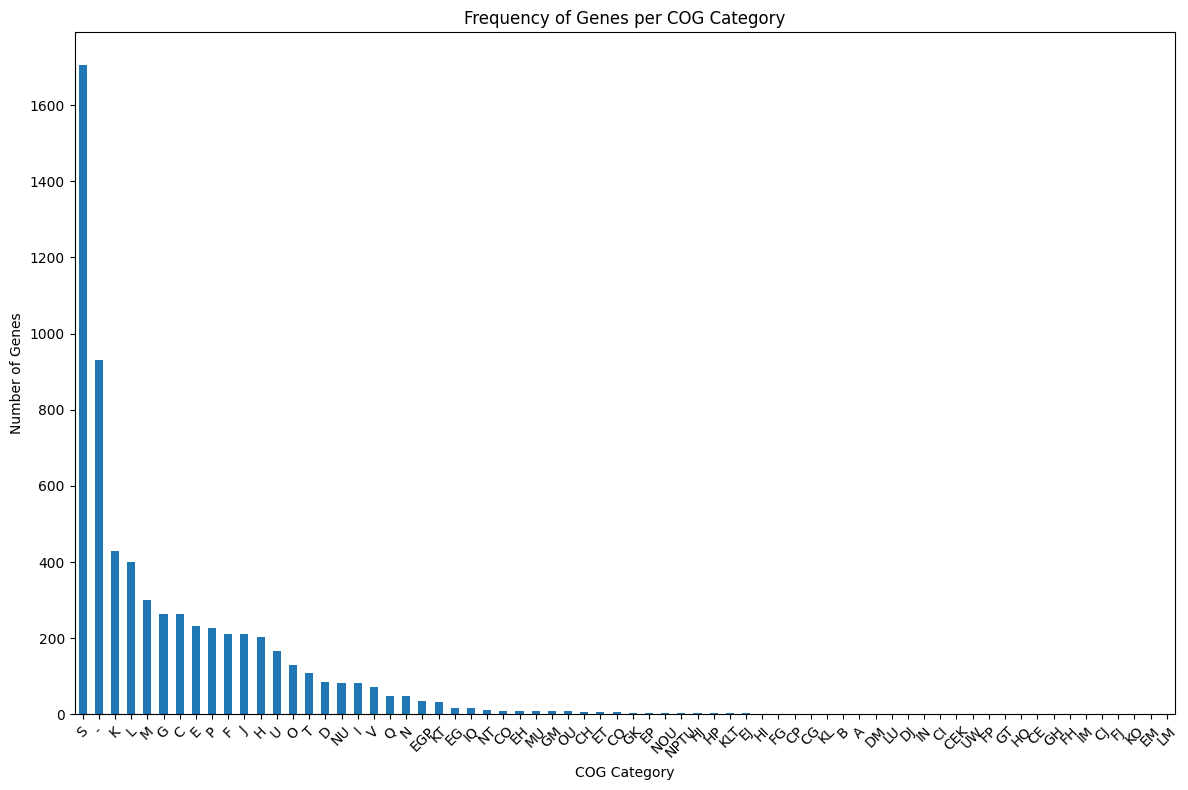

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(file_path, sep='\t', comment='#', header=None,
                   usecols=[6, 7], names=['COG_category', 'Description'])

# Data preparation: Count the frequency of each COG category
cog_counts = data['COG_category'].value_counts().head(15)

# Visualization: Plotting the bar chart
plt.figure(figsize=(12, 8))
cog_counts.plot(kind='bar')
plt.title('Frequency of Genes per COG Category')
plt.xlabel('COG Category')
plt.ylabel('Number of Genes')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

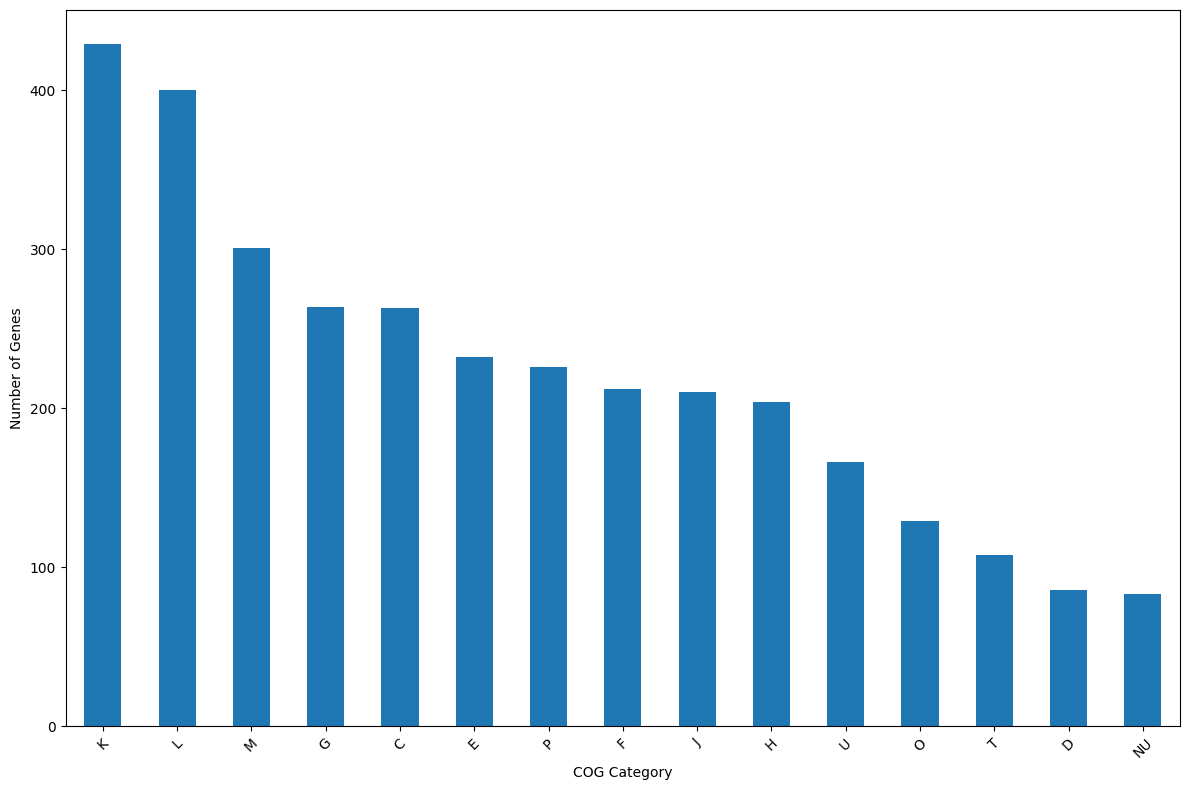

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
data = pd.read_csv(file_path, sep='\t', comment='#', header=None,
                   usecols=[6, 7], names=['COG_category', 'Description'])

# Filter out entries where COG_category is 'S' or '-'
filtered_data = data[~data['COG_category'].isin(['S', '-'])]

# Data preparation: Count the frequency of each COG category and select the top 10
cog_counts_top10 = filtered_data['COG_category'].value_counts().head(15)

# Visualization: Plotting the bar chart for the top 10 COG categories
plt.figure(figsize=(12, 8))
cog_counts_top10.plot(kind='bar')
plt.xlabel('COG Category')
plt.ylabel('Number of Genes')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to not cut off labels
plt.savefig("Results_PDF/COG_values.pdf", dpi=600)

In [8]:
data = pd.read_csv(file_path, sep='\t', comment='#', header=None)
data

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,GCA_001756025_CP074663.1_1,90371.CY43_19920,0.000000e+00,915.0,"COG0593@1|root,COG0593@2|Bacteria,1MU5H@1224|P...",1236|Gammaproteobacteria,L,it binds specifically double-stranded DNA at a...,dnaA,"GO:0000166,GO:0003674,GO:0003676,GO:0003677,GO...",...,ko:K02313,"ko02020,ko04112,map02020,map04112",-,-,-,"ko00000,ko00001,ko03032,ko03036",-,-,-,"Bac_DnaA,Bac_DnaA_C,DnaA_N"
1,GCA_001756025_CP074663.1_33,90371.CY43_19755,0.000000e+00,1045.0,"COG2985@1|root,COG2985@2|Bacteria,1MUVM@1224|P...",1236|Gammaproteobacteria,U,Predicted Permease Membrane Region,yidE,"GO:0005575,GO:0005623,GO:0005886,GO:0016020,GO...",...,ko:K07085,-,-,-,-,ko00000,2.A.81,-,-,"Asp-Al_Ex,TrkA_C"
2,GCA_001756025_CP074663.1_65,90371.CY43_19590,7.680000e-84,247.0,"COG4737@1|root,COG4737@2|Bacteria,1RHYP@1224|P...",1236|Gammaproteobacteria,S,RelE family toxin-antitoxin system,-,-,...,-,-,-,-,-,-,-,-,-,RelE
3,GCA_001756025_CP074663.1_97,90371.CY43_19435,5.290000e-265,728.0,"COG0786@1|root,COG0786@2|Bacteria,1MVBC@1224|P...",1236|Gammaproteobacteria,P,Catalyzes the sodium-dependent transport of gl...,gltS,"GO:0003333,GO:0003674,GO:0005215,GO:0005283,GO...",...,ko:K03312,-,-,-,-,"ko00000,ko02000",2.A.27,-,iZ_1308.Z5081,Glt_symporter
4,GCA_001756025_CP074663.1_161,90371.CY43_19120,1.520000e-137,389.0,"COG0625@1|root,COG0625@2|Bacteria,1RHSK@1224|P...",1236|Gammaproteobacteria,O,"Glutathione S-transferase, C-terminal domain",yibF,"GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...",...,ko:K00799,"ko00480,ko00980,ko00982,ko00983,ko01524,ko0520...",-,"R03522,R07002,R07003,R07004,R07023,R07024,R070...","RC00004,RC00069,RC00840,RC00948,RC01704,RC0170...","ko00000,ko00001,ko01000,ko02000","1.A.12.2.2,1.A.12.3.2",-,-,"GST_C,GST_C_2,GST_N_3"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6435,GCA_021309055_ABEMBW010000009.1_90,215158.Q858G5_BPE15,1.010000e-73,221.0,"4QH1B@10239|Viruses,4QXS0@35237|dsDNA viruses ...",10744|Podoviridae,S,"viral capsid, decoration",-,-,...,-,-,-,-,-,-,-,-,-,-
6436,GCA_021309055_ABEMBW010000009.1_91,1327941.T1SBI0_9CAUD,2.350000e-145,409.0,"4QBMX@10239|Viruses,4QV9I@35237|dsDNA viruses ...",10744|Podoviridae,S,Pfam:Tube,-,"GO:0005575,GO:0019012",...,-,-,-,-,-,-,-,-,-,-
6437,GCA_021309175_ABEMBU010000035.1_2,1332071.L581_3875,0.000000e+00,1071.0,"COG2274@1|root,COG2274@2|Bacteria,1R2T0@1224|P...",1236|Gammaproteobacteria,V,Peptidase C39 family,mchF,-,...,"ko:K06147,ko:K13409","ko02010,ko04626,map02010,map04626",M00339,-,-,"ko00000,ko00001,ko00002,ko02000,ko02044","3.A.1.106,3.A.1.109,3.A.1.110,3.A.1.21",-,-,"ABC_membrane,ABC_tran,Peptidase_C39,cNMP_binding"
6438,GCA_021309175_ABEMBU010000035.1_3,199310.c1233,7.220000e-74,230.0,"COG1266@1|root,COG1266@2|Bacteria,1REKA@1224|P...",1236|Gammaproteobacteria,S,CAAX protease self-immunity,-,-,...,ko:K07052,-,-,-,-,ko00000,-,-,-,Abi


In [9]:
data = pd.read_csv(file_path, sep='\t', comment='#', header=None,
                   usecols=[0, 6, 7], names=['Gene','COG_category', 'Description'])
data

,Gene,COG_category,Description
0,GCA_001756025_CP074663.1_1,L,it binds specifically double-stranded DNA at a...
1,GCA_001756025_CP074663.1_33,U,Predicted Permease Membrane Region
2,GCA_001756025_CP074663.1_65,S,RelE family toxin-antitoxin system
3,GCA_001756025_CP074663.1_97,P,Catalyzes the sodium-dependent transport of gl...
4,GCA_001756025_CP074663.1_161,O,"Glutathione S-transferase, C-terminal domain"
...,...,...,...
6435,GCA_021309055_ABEMBW010000009.1_90,S,"viral capsid, decoration"
6436,GCA_021309055_ABEMBW010000009.1_91,S,Pfam:Tube
6437,GCA_021309175_ABEMBU010000035.1_2,V,Peptidase C39 family
6438,GCA_021309175_ABEMBU010000035.1_3,S,CAAX protease self-immunity


In [12]:
subset_data = pd.DataFrame(columns=data.columns)
for gene in features:
    subset_data = pd.concat([subset_data, data[data['Gene'] == gene]])
subset_data

,Gene,COG_category,Description
2832,GCA_016688895_AAYTJN010000012.1_80,M,Enterobacterial Ail/Lom protein
6298,GCA_021224775_ABEIJN010000068.1_3,-,-
1525,GCA_009161025_CP082429.1_1257,S,DMSO reductase anchor subunit (DmsC)
1486,GCA_008945185_CP082473.1_4444,G,Involved in the anomeric conversion of L-rhamnose
2280,GCA_011408855_CP082751.1_1550,S,G-rich domain on putative tyrosine kinase
2604,GCA_016588255_AAYQXL010000008.1_118,S,Salmonella invasion protein A
4979,GCA_018280245_ABAJPK010000005.1_223,S,Ead/Ea22-like protein
1431,GCA_008945185_CP082473.1_1788,H,Tetrapyrrole (Corrin/Porphyrin) Methylases
3715,GCA_017008735_AAYXZN010000009.1_113,T,PAS domain


In [13]:
subset_data.to_csv('Results_PDF/Functions_Top10Genes.csv', index=False)